In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

## ConvNet

We have seen what we can do with initialization, but to train really deep networks we need other tricks. One can use SeLU or mixup(?), but these are super-fiddly. J.H. would rather use the Layer-wise Sequential Unit Variance (**LSUV**) that we will encounter in one of the next notebooks. With just initialization, this is as far as we can go, but to go further, we need *normalization*, and in particular Batch Normalization.

The Batch Normalization paper shows the algorithm to be used, and it contains two parameters to be learned: $\gamma$ and $\beta$. In a neural network there are two main quantities: *parameters*, that are things we *learn*, and *activations*, that are things we *calculate*.

Let's get the data and training interface from where we left in the last notebook.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [5]:
nfs = [8, 16, 32, 64, 64]

0.4 was the highest learning rate we could get in our previous run.

In [6]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train: [1.26641609375, tensor(0.5915, device='cuda:0')]
valid: [0.2634784423828125, tensor(0.9196, device='cuda:0')]
train: [0.19993935546875, tensor(0.9394, device='cuda:0')]
valid: [0.14768394775390625, tensor(0.9575, device='cuda:0')]
CPU times: user 2.72 s, sys: 509 ms, total: 3.23 s
Wall time: 3.11 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

We compute the mean and the variance with the method `update_stats()`. Just to confuse things, J.H. calls $\gamma$ and $\beta$ `self.mults` (the thing that multiplies) and `self.adds` (the thing that adds). Why, oh why...

`self.mults` and `self.adds` are initialized in `__init__()` as `nn.Parameters` of, respectively, ones and zeros (neutral for multiplication and addition). `self.adds` is conceptually identical to *bias*.

There are a couple of things we have to keep track of: the first one is what happens at inference time. We want to normalize at training time, but if we normalize at inference time, we may be removing the interesting stuff (**Unclear - clarify**).

While we are training, we keep an exponentially moving average of the means and the variances, stored in `self.means.lerp_` and `self.vars.lerp_`. These are running averages of the last few batches. Then, at inference time, we don't use the current mean and variance, but rather these running averages.

In `__init__` we don't assign the mean and variance to `self` but rather we do:

```python
self.register_buffer('vars', torch.ones(1, nf, 1, 1))
self.register_buffer('means', torch.zeros(1, nf, 1, 1))
```

`register_buffer()` has two advantages: if we move the model to the GPU, anything registered with `register_buffer()` will also be moved to the GPU. The other nice thing is that the mean and the variance are part of the model. When we save the model, `register_buffer()` also forces the registered quantities to be saved.

When we compute the mean and the variance we averages over axes `(0, 2, 3)`, *i.e.*, over all the batches, and over all the x and y coordinates. We are therefore left only for a mean for each channel.

Why do we use an exponential moving average and not a standard moving average? In a standard moving average we would take a subset of the points, average, move one point to the right, average and so on. The problem is that in real models we can have hundreds of millions of parameters, and this becomes very expensive. Exponential Moving Averages use a nifty trick, of adding one value at a time, but applying the formula

$$\mu_{t} = \beta \mu_{t-1} + (1 - \beta) x_{t}$$

With this trick, the influence of the previous points decays exponentially. The formula above is a *linear interpolation* between $\mu_{t-1}$ and $x_t$, and in PyTorch, linear interpolation is obtained with the method `lerp()`. Typically, the *momentum* in an Exponential Moving Average would be $\beta \approx 0.9$, but `lerp()` uses the opposite, and we have to pass, as a momentum, $1 - \beta$. This is also how `nn.BatchNorm` works **check the code**.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6018)

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom = mom
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars',  torch.ones(1, nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))

    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x-m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

We create a new `conv_layer()` function that can optionally add a `BatchNorm` layer. If we add a `BatchNorm` layer, we remove the bias because the `self.adds` is already a bias.

In [9]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn:
        layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

`init_cnn_` is a *recursive* initialization that will go through all the parameters.

In [10]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None:
            m.bias.data.zero_()
    for l in m.children():
        init_cnn_(l, f)


def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)


def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None,
                  uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [11]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.29185966796875, tensor(0.9074, device='cuda:0')]
valid: [0.18233570556640624, tensor(0.9417, device='cuda:0')]


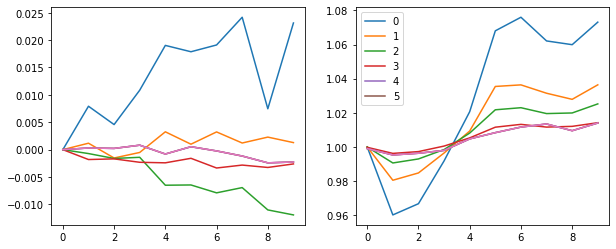

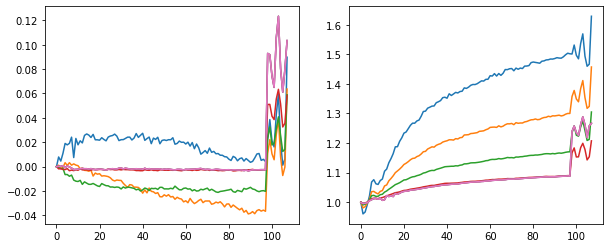

In [12]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

Our training has gotten rid of all the exponential peaks and sudden crashes. There is something happening at the end of training, and we don't know what it is. Now we can push the learning rate of 1.0 and we have 97%.

In [13]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [14]:
%time run.fit(3, learn)

train: [0.27808982421875, tensor(0.9135, device='cuda:0')]
valid: [0.162999853515625, tensor(0.9475, device='cuda:0')]
train: [0.09739609375, tensor(0.9698, device='cuda:0')]
valid: [0.1759537109375, tensor(0.9469, device='cuda:0')]
train: [0.06953375, tensor(0.9776, device='cuda:0')]
valid: [0.09662073974609375, tensor(0.9707, device='cuda:0')]
CPU times: user 2.42 s, sys: 256 ms, total: 2.68 s
Wall time: 2.69 s


### Builtin batchnorm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6679)

Now that we have built our own `BatchNorm`, we can use PyTorch's `nn.BatchNorm` and see that we obtain pretty much the same results.

In [15]:
# export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn:
        layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [16]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [17]:
%time run.fit(3, learn)

train: [0.28721205078125, tensor(0.9130, device='cuda:0')]
valid: [0.1428540771484375, tensor(0.9561, device='cuda:0')]
train: [0.0813247998046875, tensor(0.9740, device='cuda:0')]
valid: [0.110000634765625, tensor(0.9650, device='cuda:0')]
train: [0.0591580224609375, tensor(0.9810, device='cuda:0')]
valid: [0.0665137451171875, tensor(0.9799, device='cuda:0')]
CPU times: user 2.27 s, sys: 213 ms, total: 2.49 s
Wall time: 2.49 s


### With scheduler

Now let's add the usual warm-up/annealing, and push the learning rate up to 2.0, and we get almost at 99%.

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [19]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                           + [partial(ParamScheduler, 'lr', sched)])

In [20]:
run.fit(8, learn)

train: [0.31099466796875, tensor(0.9105, device='cuda:0')]
valid: [0.4049222900390625, tensor(0.8717, device='cuda:0')]
train: [0.09214541015625, tensor(0.9714, device='cuda:0')]
valid: [0.0985653564453125, tensor(0.9705, device='cuda:0')]
train: [0.0647019677734375, tensor(0.9790, device='cuda:0')]
valid: [0.07347146606445312, tensor(0.9753, device='cuda:0')]
train: [0.03867027099609375, tensor(0.9877, device='cuda:0')]
valid: [0.06002353515625, tensor(0.9804, device='cuda:0')]
train: [0.02480046630859375, tensor(0.9923, device='cuda:0')]
valid: [0.04955558471679687, tensor(0.9843, device='cuda:0')]
train: [0.016074166259765627, tensor(0.9953, device='cuda:0')]
valid: [0.046943875122070315, tensor(0.9859, device='cuda:0')]
train: [0.010006414794921875, tensor(0.9975, device='cuda:0')]
valid: [0.042490869140625, tensor(0.9871, device='cuda:0')]
train: [0.007036358032226563, tensor(0.9987, device='cuda:0')]
valid: [0.043696853637695314, tensor(0.9869, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

If we have a batch size of 1 the variance is infinite, so batch-norm does not makes sense. If we have a segmentation task, with batch size of 2, we also have a problem, because at some point two values will be very similar, and we will be dividing by a variance or almost zero, so we will have unstable or impossible training.

It's also hard for RNNs (**I haven't understood the explanation of why it is a problem**). The paper above suggests the solution to these problems.

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In other words we get rid of all the Exponential Moving Averages, and we average over (1, 2, 3) rather than (0, 2, 3). Every image has its own mean and its own standard deviations, we don't average over the batches any more, but we do average over the channels.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6717)

In [21]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']

    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var((1, 2, 3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [22]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn:
        layers.append(LayerNorm())
    return nn.Sequential(*layers)

The problem is that if we train, even at a lower learning rate, it doesn't work. We don't have a different normalization for each channel, and therefore we treat things as if they were the same, but they are not. In other words, `LayerNorm` can help for images, but it's not nearly as good as `BatchNorm`. For RNNs, however, this is what you have to use.

In [23]:
learn, run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [24]:
%time run.fit(3, learn)

train: [nan, tensor(0.1174, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 2.78 s, sys: 281 ms, total: 3.06 s
Wall time: 3.07 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

Foggy days will have 1) less activations on average as they are less bright, 2) less contrast, i.e. less average. `LayerNorm` will normalize the means to be the same and the variances to be the same, so now they sunny day picture and the hazy day picture will have the same amount of activation and of contrast, so the answer to the question is no. If you put it anywhere in the middle layers, the answer is the same.

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}
\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}
\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

So `InstanceNorm` averages over the indices (2, 3)

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [25]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']

    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))

    def forward(self, x):
        m = x.mean((2, 3), keepdim=True)
        v = x.var((2, 3), keepdim=True)
        res = (x-m) / ((v + self.eps).sqrt())
        return res*self.mults + self.adds

In [26]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn:
        layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

`InstanceNorm` even at a learning rate of 0.1 doesn't learn anything at all. Why? Because we are averaging over every channell and every image and throwing away anything that can distinguish them.

`InstanceNorm` was not designed for classification, but rather for style transfer where the authors guessed that the difference in contrast and overall amount were not important and could be removed. So there are many types of normalization, but you need to understand what each one of them does.

In [27]:
learn, run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [28]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 2.8 s, sys: 269 ms, total: 3.07 s
Wall time: 3.08 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) show the differences between the various types of normalization. Note that in `GroupNorm` the normalization arbitrarily operates on a group of channels.

![Various norms](images/norms.png)

### Group norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7213)

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

There are a number of different approaches to normalization, but we have seen none of them is as good as `BatchNorm`. We don't know how to fix the problem for RNNs, but we may know how to fix the problem for small batches.

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

We create a new `DataBunch` with a batch size of 2. If we run it we see it takes a long time, which makes sense. There is a lot of GPU overhead, so much that it may be faster on the CPU. The performance is also awful, because of the small batch size.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7304)

In [29]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [30]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn:
        layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [31]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [32]:
%time run.fit(1, learn)

train: [2.3377259375, tensor(0.1902, device='cuda:0')]
valid: [4.266536328125, tensor(0.2266, device='cuda:0')]
CPU times: user 51.8 s, sys: 533 ms, total: 52.3 s
Wall time: 52.5 s


### Running Batch Norm

In our `BatchNorm` above we included `self.eps` to avoid divisions by zero. But what if, instead of a fixed value, we *learn* it? If instead of 1e-5 we use `self.eps = 0.01`, even in the worst case, we would be multiplying by 10 (mind the square root) so it wouldn't easily blow up.

An even better solution is to introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std. The idea is not to subtract the batch mean and divide by the batch standard deviation, but rather use the moving average statistics at training time as well, and not just at training time. According to J.H., even if you happen to have a very small variance, which will happen with small sample sizes, this will have a much smaller impact.

There are a number of details:

1. In `BatchNorm` we take the running average of the variance. J.H. says that you cannot take the average of variances. He uses the $E[X^2] - E^2[X]$ formula for this. **TODO: LOOK AT THE CODE**.
2. The batch size may vary so they are also taking a moving average of the batch sizes.
3. We need to do *debiasing*: we want to make sure that no observation is weighted too highly. The first point gets too much weight. You initialize both `sums` and `sqrs` to zero, then you do the `lerp()`. We have an exponentially debiased amount and we divide by the debiased amount.
4. If your first minibatch is really close to zero, that will ruin everything, so there is an additional guard rail that says "clamp the first 20 values to 0.01.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7516)

In [33]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom = mom
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('sums', torch.zeros(1, nf, 1, 1))
        self.register_buffer('sqrs', torch.zeros(1, nf, 1, 1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel() / nc)
        mom1 = 1 - (1 - self.mom) / math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias * (1 - self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training:
            self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step < 100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c = c / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20):
            vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [34]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn:
        layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [35]:
learn, run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [36]:
%time run.fit(1, learn)

train: [0.360621328125, tensor(0.9081, device='cuda:0')]
valid: [0.16680057373046875, tensor(0.9611, device='cuda:0')]
CPU times: user 2min 11s, sys: 1.37 s, total: 2min 13s
Wall time: 2min 13s


This solves the small batch size issue!

### What can we do in a single epoch?

What is the best accuracy you can get *in a single epoch*?
Now let's see with a decent batch size what result we can get.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=8068)

In [37]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [38]:
learn, run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                           + [partial(ParamScheduler, 'lr', sched_lin(1., 0.2))])

In [39]:
%time run.fit(1, learn)

train: [0.153632080078125, tensor(0.9540, device='cuda:0')]
valid: [0.06667882690429687, tensor(0.9805, device='cuda:0')]
CPU times: user 8.09 s, sys: 104 ms, total: 8.19 s
Wall time: 8.25 s


## Simplified RunningBatchNorm

Stas Bekman noticed that we don't actually need to debias in the calculation above. In the code in this snippet

```python
sums = sums / self.dbias
sqrs = sqrs / self.dbias
c = c / self.dbias
```

there is no point in dividing by `self.dbias`. This means that we can remove all the debiasing and end up with something simpler.
Tom Viehmann also found a way to simplify these calculations.

**Important**: the simplified version is not on GitHub, I don't know why. Someone asked this same question [on the forum](https://forums.fast.ai/t/simplified-runningbatchnorm-in-lesson-11/56340).

## Export

In [40]:
nb_auto_export()

<IPython.core.display.Javascript object>